样本不均衡是指在一组数据集中，标签的一类天生占有很大的比例，但有着捕捉出某种特定类别的需求的状况。这样的标签分布会带来许多问题。首先，分类模型天生会倾向于多数的类，让多数类更容易被判断正确，少数类被牺牲掉。其次，模型评估指标会失去意义。所以首先要让算法意识到数据的标签是不均衡的，通过**施加惩罚**或者**改变样本本身**，来让模型向着捕获少数类的方向建模。然后，**改进模型评估指标**，使用更加针对于少数类的指标来优化模型。

要解决第一个问题，在逻辑回归中已经介绍了一些基本方法，比如**上采样下采样**。但这些采样方法会增加样本的总数，而在支持向量机中，样本总数对计算速度影响巨大，且支持向量机中的决策仅仅受到决策边界的影响，而决策边界又仅仅受到参数C和支持向量的影响，单纯地增加样本数量不仅会增加计算时间，可能还会增加无数对决策边界无影响的样本点。因此在支持向量机中，要大力依赖调节样本均衡的参数：SVC类中的class\_weight和接口fit中可以设定的sample\_weight。

**SVC的参数：class\_weight**

class_weight={'标签的值1'：权重1，'标签的值2'：权重2}<br>
此时参数C自动被设为：<br>
标签的值1的C：权重1\*C，标签的值2的C：权重2\*C

**SVC的接口fit的参数：sample\_weight**

数组，结构为(n_samples, )，必须对应输入fit中的特征矩阵的每个样本。<br>
每个样本在fit时的权重，让权重\*每个样本对应的C值来迫使分类器强调设定的权重更大的样本。通常，较大的权重加在少数类的样本上，以迫使模型向着少数类的方向建模。

通常来说，这两个参数只选取一个来设置。如果同时设置了两个参数，则C会同时受到两个参数的影响，即class\_weight中设定的权重\*sample\_weight中设定的权重\*C。

**1.导入需要的库和模块**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.datasets import make_blobs

**2.创建样本不均衡的数据集**

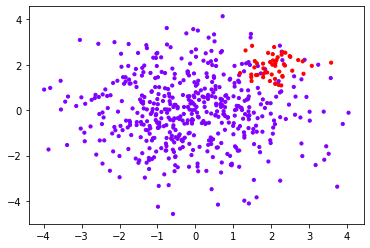

In [2]:
class_1 = 500 #类别1有500个样本
class_2 = 50 #类别2只有50个
centers = [[0.0, 0.0], [2.0, 2.0]] #设定两个类别的中心
clusters_std = [1.5, 0.5] #设定两个类别的方差，通常来说，样本量比较大的类别会更加松散
X, y = make_blobs(n_samples=[class_1, class_2],
                  centers=centers,
                  cluster_std=clusters_std,
                  random_state=0,
                  shuffle=False)
#看看数据集长什么样
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="rainbow",s=10)#其中红色点是少数类，紫色点是多数类
plt.show()

**3.在数据集上分别建模**

In [3]:
#不设定class_weight
clf = svm.SVC(kernel='linear', C=1.0)
clf.fit(X, y)

SVC(kernel='linear')

In [4]:
#设定class_weight
wclf = svm.SVC(kernel='linear', class_weight={1: 10})
wclf.fit(X, y)

SVC(class_weight={1: 10}, kernel='linear')

In [5]:
#给两个模型分别打分看看，这个分数是accuracy准确度
clf.score(X,y)

0.9418181818181818

In [6]:
wclf.score(X,y)

0.9127272727272727

做样本均衡之后，模型的准确度下降了。

**4.绘制两个模型下数据的决策边界**

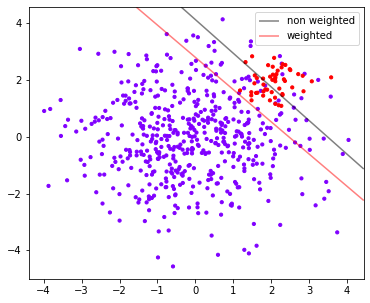

In [7]:
#首先要有数据分布
plt.figure(figsize=(6,5))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='rainbow',s=10)
ax = plt.gca() #获取当前的子图，如果不存在，则创建新的子图

#绘制决策边界的第一步：要有网格
xlim = ax.get_xlim()
ylim = ax.get_ylim()
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T

#第二步：找出我们的样本点到决策边界的距离
Z_clf = clf.decision_function(xy).reshape(XX.shape)
a = ax.contour(XX, YY, Z_clf, colors='black', levels=[0], alpha=0.5, linestyles=['-'])
Z_wclf = wclf.decision_function(xy).reshape(XX.shape)
b = ax.contour(XX, YY, Z_wclf, colors='red', levels=[0], alpha=0.5, linestyles=['-'])

#第三步：画图例
#plt.legend([对象列表],[图例列表],loc)，只要对象列表和图例列表相对应，就可以显示出图例
plt.legend([a.collections[0],b.collections[0]]
           ,['non weighted', 'weighted']
           ,loc='upper right')
plt.show()

In [8]:
a.collections #调用这个等高线对象中画的所有线，返回一个惰性对象

<a list of 1 mcoll.LineCollection objects>

In [9]:
#用[*]把它打开试试看
[*a.collections] #返回了一个linecollection对象，其实就是等高线里所有的线的列表

In [10]:
#现在我们只有一条线，所以我们可以使用索引0来锁定这个对象
a.collections[0]

做样本平衡前，大约有一半少数类（红色）被分错，多数类（紫色点）几乎都被分类正确了。做了样本平衡后，少数类几乎全部都被分类正确了，但是多数类有许多被分错了。